# Installation / Import des librairies

In [ ]:
# !pip install h5py
# !pip install scikit-learn
# !pip install mlxtend # Pour les spindles
# !pip install --upgrade yasa
# !pip install shap
# !pip install BorutaShap
# !pip install boruta
# !pip install boostaroota

In [ ]:
# Installer la librairie entropy (liée à yasa)
!git clone https://github.com/raphaelvallat/entropy.git entropy/
!cd entropy/
!pip install -r "entropy/requirements.txt"
!python "entropy/setup.py" develop

In [ ]:
# Installer librairie pyeeg (pour les hjorth params et l'information de Fisher)
!git clone https://github.com/forrestbao/pyeeg.git
!cd pyeeg
!python "pyeeg/setup.py" install
!python "pyeeg/setup.py" test

In [ ]:
import h5py    
import numpy as np
import yasa
from entropy import entropy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyeeg import pyeeg
from tqdm.notebook import tqdm
from scipy.signal import welch
from scipy.integrate import simps
from scipy import stats

In [ ]:
# Inutile si pas sur un google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Recupération des données Xtrain / Xtest / Ytrain

In [ ]:
# Laurent

# Train
with h5py.File("/content/drive/MyDrive/Centrale Supelec/ML/X_train.h5",'r') as f:
    eeg_1 = f['eeg_1'][()]
    eeg_2 = f['eeg_2'][()]
    eeg_3 = f['eeg_3'][()]
    eeg_4 = f['eeg_4'][()]
    eeg_5 = f['eeg_5'][()]
    eeg_6 = f['eeg_6'][()]
    eeg_7 = f['eeg_7'][()]
    index = f['index'][()]
    index_absolute = f['index_absolute'][()]
    index_window = f['index_window'][()]
    pulse = f['pulse'][()]
    x = f['x'][()]
    y = f['y'][()]
    z = f['z'][()]

# Test
with h5py.File("/content/drive/MyDrive/Centrale Supelec/ML/X_test.h5",'r') as f:
    eeg_test_1 = f['eeg_1'][()]
    eeg_test_2 = f['eeg_2'][()]
    eeg_test_3 = f['eeg_3'][()]
    eeg_test_4 = f['eeg_4'][()]
    eeg_test_5 = f['eeg_5'][()]
    eeg_test_6 = f['eeg_6'][()]
    eeg_test_7 = f['eeg_7'][()]
    index_test = f['index'][()]
    index_absolute_test = f['index_absolute'][()]
    index_window_test = f['index_window'][()]
    pulse_test = f['pulse'][()]
    x_test = f['x'][()]
    y_test = f['y'][()]
    z_test = f['z'][()]

Y_train = pd.read_csv("/content/drive/MyDrive/Centrale Supelec/ML/y_train.csv",sep=',',decimal=",")

In [ ]:
# Antoine

# Train
with h5py.File("/content/drive/MyDrive/Colab Notebooks Centrale/Projet ML/datas/X_train.h5/X_train.h5",'r') as f:
    eeg_1 = f['eeg_1'][()]
    eeg_2 = f['eeg_2'][()]
    eeg_3 = f['eeg_3'][()]
    eeg_4 = f['eeg_4'][()]
    eeg_5 = f['eeg_5'][()]
    eeg_6 = f['eeg_6'][()]
    eeg_7 = f['eeg_7'][()]
    index = f['index'][()]
    index_absolute = f['index_absolute'][()]
    index_window = f['index_window'][()]
    pulse = f['pulse'][()]
    x = f['x'][()]
    y = f['y'][()]
    z = f['z'][()]

# Test
with h5py.File("/content/drive/MyDrive/Colab Notebooks Centrale/Projet ML/datas/X_test.h5",'r') as f:
    eeg_test_1 = f['eeg_1'][()]
    eeg_test_2 = f['eeg_2'][()]
    eeg_test_3 = f['eeg_3'][()]
    eeg_test_4 = f['eeg_4'][()]
    eeg_test_5 = f['eeg_5'][()]
    eeg_test_6 = f['eeg_6'][()]
    eeg_test_7 = f['eeg_7'][()]
    index_test = f['index'][()]
    index_absolute_test = f['index_absolute'][()]
    index_window_test = f['index_window'][()]
    pulse_test = f['pulse'][()]
    x_test = f['x'][()]
    y_test = f['y'][()]
    z_test = f['z'][()]
  
Y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks Centrale/Projet ML/datas/y_train.csv",sep=',',decimal=",")

# Features extraction : utiliser le Features_train.csv / Features_test.csv une fois créé.

In [ ]:
import pandas as pd
Y_train = pd.read_csv("y_train.csv",sep=',',decimal=",")

In [ ]:
features_test = pd.read_csv("Features_test.csv")

In [ ]:
features_train = pd.read_csv("Features_train.csv")

##  Quantiles & Moments (asolute mean, variance, skew, kurtosis)

In [ ]:
def quantile_signal(eeg):
  q = [0.25,0.5,0.75]
  res = np.zeros((eeg.shape[0],len(q)))
  for i in tqdm(range(len(q))):
    res[:,i] = np.array(np.quantile(eeg,q[i], axis=1))
  return res

In [ ]:
def absolute_mean(eeg):
  return np.array([np.abs(np.mean(eeg[i,:])) for i in range(eeg.shape[0])])

def variance_signal(eeg):
  return np.array([np.abs(np.var(eeg[i,:])) for i in range(eeg.shape[0])])

def skew_signal(eeg):
  return np.array([stats.skew(eeg[i,:]) for i in range(eeg.shape[0])])

def kurtosis_signal(eeg):
    return np.array([stats.kurtosis(eeg[i,:]) for i in range(eeg.shape[0])])

## Band Power



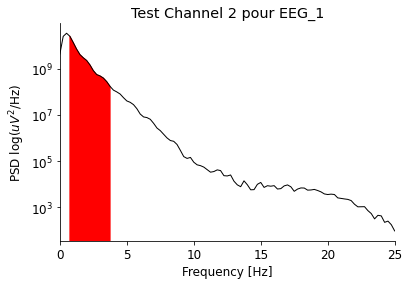

In [ ]:
# Exemple avec 2eme epoch du eeg_1 pour la bande de fréquence Delta
freq, psd = welch(eeg_1, 50, nperseg=4*50) # psd de shape (nb_epoch, nb_freq)
plt.plot(freq, psd[1], 'black', lw=1)
plt.fill_between(freq, psd[1], where=(freq > 0.5) & (freq < 4), cmap='Spectral', color="red")
plt.xlim(0, 25)
plt.yscale('log')
sns.despine()
plt.title("Test Channel 2 pour EEG_1")
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD log($uV^2$/Hz)');

In [ ]:
# Fonction récupérant les bandpowers pour les 4 désirées
def classic_spectral_power(eeg, sf):
  freqs, psd = welch(eeg, sf, nperseg=int(4 * sf))
  return yasa.bandpower_from_psd_ndarray(psd, freqs, bands=[(0.5,4,'Delta'), (4,8,'Theta'), (8,12, 'Alpa'), (12,30,'Beta')])

## Entropy & Dimentions Fractales

In [ ]:
def Entrop_features(eeg):
  results = np.zeros((4,eeg.shape[0]))
  for i in tqdm(range(eeg.shape[0]), desc="Entropy"):
    results[0,i] = entropy.perm_entropy(eeg[i,:], order=3, normalize=True)
    results[1,i] = entropy.svd_entropy(eeg[i,:], order=3,delay=1, normalize=True) 
    results[2,i] = entropy.app_entropy(eeg[i,:], order=2, metric='chebyshev')
    results[3,i] = entropy.lziv_complexity(eeg[i,:] > eeg[i,:].mean(), normalize=True)
    # results[4,i] = entropy.sample_entropy(eeg[i,:], order=2, metric='chebyshev')
  return results

In [ ]:
def Fractal_features(eeg):
  results = np.zeros((4,eeg.shape[0]))
  for i in tqdm(range(eeg.shape[0]), desc="Fractal dimensions"):
    results[0,i] = entropy.fractal.petrosian_fd(eeg[i,:]) 
    results[1,i] = entropy.fractal.katz_fd(eeg[i,:])
    results[2,i] = entropy.fractal.higuchi_fd(eeg[i,:])
    results[3,i] = entropy.fractal.detrended_fluctuation(eeg[i,:])
  return results

## Hjorth Parameters

In [ ]:
def hjorth_params(eeg): # Pour mobilité et complexité
  mobility = np.zeros(eeg.shape[0])
  complexity = np.zeros(eeg.shape[0])
  for i in tqdm(range(eeg.shape[0]), desc="Hjorth Parameters"):
    mobility[i], complexity[i] = pyeeg.hjorth(eeg[i,:])
  return mobility, complexity

## Fisher information

In [ ]:
def fisher_inf(eeg):
  return np.array([pyeeg.fisher_info(eeg[i,:], 1, 2) for i in range(eeg.shape[0])]) 

## Spindles

In [ ]:
def spindles_mean_count(eeg): 
  mean_amp = np.zeros(eeg.shape[0])
  nb_spind = np.zeros(eeg.shape[0])
  for i in tqdm(range(eeg.shape[0]), desc="Spindles"):
    mean_amp[i] = spindles_detect(eeg[i,:], 50)[1]["Amplitude (uV)"].mean()
    nb_spind[i] = len(spindles_detect(eeg[i,:], 50)[1]["Amplitude (uV)"])
  return nb_spind, mean_amp

In [ ]:
from scipy.signal import detrend
from mne.time_frequency import morlet, psd_array_multitaper

def spindles_detect(x, sf, thresh=0.25, wlt_params={'nc': 12, 'cf': 'auto'}):

    if wlt_params['cf'] == 'auto':
        # Comme pour les bandes plus haut, et on prend le pique de 11-16Hz
        psd, freqs = psd_array_multitaper(x, sf, fmin=11, fmax=16, verbose=0)
        wlt_params['cf'] = freqs[np.argmax(psd)]
        print('Central frequency: %.2f Hz' % wlt_params['cf'])

    # Convulution des data avec wavelet
    wlt = morlet(sf, [wlt_params['cf']], n_cycles=wlt_params['nc'])[0]
    analytic = np.convolve(x, wlt, mode='same')
    phase = np.angle(analytic)

    # Normalisation
    power = np.square(np.abs(analytic))
    norm_power = (power - power.min()) / (power.max() - power.min())

    # Supra-threasold
    supra_thresh_bool = norm_power >= thresh
    supra_thresh_idx = np.where(supra_thresh_bool)[0]

    # Pour la duration, fréquence et amplitude
    sp = np.split(supra_thresh_idx, np.where(np.diff(supra_thresh_idx) != 1)[0] + 1)
    idx_start_end = np.array([[k[0], k[-1]] for k in sp])
    sp_dur = (np.diff(idx_start_end, axis=1) / sf).flatten() * 1000
    sp_amp, sp_freq = np.zeros(len(sp)), np.zeros(len(sp))
    for i in range(len(sp)):
        sp_amp[i] = np.ptp(detrend(x[sp[i]]))
        sp_freq[i] = np.median((sf / (2 * np.pi) * np.diff(phase[sp[i]])))

    sp_params = {'Duration (ms)' : sp_dur, 'Frequency (Hz)': sp_freq,
                 'Amplitude (uV)': sp_amp}

    return supra_thresh_bool, sp_params

## Concatenation de nos features

In [ ]:
def concat_features_eeg(eeg, i):
  features = pd.DataFrame()

  # Band_power
  bandpower_eeg = classic_spectral_power(eeg, 50) # (4, 24688)
  df_bandPower = pd.DataFrame(bandpower_eeg.T, columns=[f"delta_eeg{i}", f"theta_eeg{i}", f"alpha_eeg{i}", f"beta_eeg{i}"])

  # Entropy
  Entrop = Entrop_features(eeg) #(4, 24688)
  df_entropy = pd.DataFrame(Entrop.T, columns=[f"perm_entropy_eeg{i}", f"svd_entropy_eeg{i}", f"app_entropy_eeg{i}", f"lziv_complexity_eeg{i}"])

  # Fractal dimension
  Fractal = Fractal_features(eeg)
  df_fractal = pd.DataFrame(Fractal.T, columns=[f"petrosian_fd_eeg{i}", f"katz_fd_eeg{i}", f"higuchi_fd_eeg{i}", f"detrended_fluctuation_eeg{i}"])

  # Hjorth parameters
  mobility, complexity = hjorth_params(eeg)
  df_hjorth_mob = pd.DataFrame(mobility, columns=[f"hjorth_mobility_eeg{i}"])
  df_hjorth_comp = pd.DataFrame(complexity, columns=[f"hjorth_complexity_eeg{i}"])

  # Fisher information
  fisherInf = fisher_inf(eeg)
  df_fisher = pd.DataFrame(fisherInf, columns=[f"fisher_information_eeg{i}"])

  # Spindles
  nb_spind, mean_amp = spindles_mean_count(eeg)
  df_nbspind = pd.DataFrame(nb_spind, columns=[f"nb_spindles_eeg{i}"])
  df_meanampspind = pd.DataFrame(mean_amp, columns=[f"mean_amp_spindles_eeg{i}"])

  # Quantiles
  quantiles = quantile_signal(eeg)
  df_quantiles = pd.DataFrame(quantiles, columns=[f"q025_eeg{i}",f"q05_eeg{i}",f"q075_eeg{i}"])

  # Stats Moments
  eeg_mean = absolute_mean(eeg); df_eeg_mean = pd.DataFrame(eeg_mean, columns=[f"absolute_mean_eeg{i}"])
  var_eeg = variance_signal(eeg); df_var_eeg = pd.DataFrame(var_eeg, columns=[f"variance_eeg{i}"])
  skew_eeg = skew_signal(eeg); df_skew_eeg = pd.DataFrame(skew_eeg, columns=[f"skew_eeg{i}"])
  kurt_eeg = kurtosis_signal(eeg); df_kurt_eeg = pd.DataFrame(kurt_eeg, columns=[f"kurtosis_eeg{i}"])

  return pd.concat([df_bandPower, df_entropy, df_fractal, df_eeg_mean, df_var_eeg, df_skew_eeg, df_kurt_eeg, 
                    df_hjorth_mob, df_hjorth_comp, df_fisher, df_nbspind, df_meanampspind, df_quantiles], axis=1)

## Ajout de l'acceleromètre et pulse

In [ ]:
def concat_acc_pulse(features, train=True):
  if train==True:
    # abs Mean
    pulse_mean = absolute_mean(pulse); df_pulse_mean = pd.DataFrame(pulse_mean, columns=["pulse_mean"])
    x_mean = absolute_mean(x); df_x_mean = pd.DataFrame(x_mean, columns=["x_mean"])
    y_mean = absolute_mean(y); df_y_mean = pd.DataFrame(y_mean, columns=["y_mean"])
    z_mean = absolute_mean(z); df_z_mean = pd.DataFrame(z_mean, columns=["z_mean"])
    # var
    pulse_var = variance_signal(pulse); df_pulse_var = pd.DataFrame(pulse_var, columns=["pulse_var"])
    x_var = variance_signal(x); df_x_var = pd.DataFrame(x_var, columns=["x_var"])
    y_var = variance_signal(y); df_y_var = pd.DataFrame(y_var, columns=["y_var"])
    z_var = variance_signal(z); df_z_var = pd.DataFrame(z_var, columns=["z_var"])
    # Skew
    pulse_skew = skew_signal(pulse); df_pulse_skew = pd.DataFrame(pulse_skew, columns=["pulse_skew"])
    x_skew = skew_signal(x); df_x_skew = pd.DataFrame(x_skew, columns=["x_skew"])
    y_skew = skew_signal(y); df_y_skew = pd.DataFrame(y_skew, columns=["y_skew"])
    z_skew = skew_signal(z); df_z_skew = pd.DataFrame(z_skew, columns=["z_skew"])
    # Kurtosis
    pulse_kurt = kurtosis_signal(pulse); df_pulse_kurt = pd.DataFrame(pulse_kurt, columns=["pulse_kurt"])
    x_kurt = kurtosis_signal(x); df_x_kurt = pd.DataFrame(x_kurt, columns=["x_kurt"])
    y_kurt = kurtosis_signal(y); df_y_kurt = pd.DataFrame(y_kurt, columns=["y_kurt"])
    z_kurt = kurtosis_signal(z); df_z_kurt = pd.DataFrame(z_kurt, columns=["z_kurt"])
    # Quantiles
    pulse_quantile = quantile_signal(pulse); df_pulse_quantile = pd.DataFrame(pulse_quantile, columns=["q025_oth0", "q05_oth0", "q075_oth0"])
    x_quantile = quantile_signal(pulse); df_x_quantile = pd.DataFrame(x_quantile, columns=["q025_oth1", "q05_oth1", "q075_oth1"])
    y_quantile = quantile_signal(x); df_y_quantile = pd.DataFrame(y_quantile, columns=["q025_oth2", "q05_oth2", "q075_oth2"])
    z_quantile = quantile_signal(y); df_z_quantile = pd.DataFrame(z_quantile, columns=["q025_oth3", "q05_oth3", "q075_oth3"])
  elif train==False:
    pulse_mean = absolute_mean(pulse_test); df_pulse_mean = pd.DataFrame(pulse_mean, columns=["pulse_mean"])
    x_mean = absolute_mean(x_test); df_x_mean = pd.DataFrame(x_mean, columns=["x_mean"])
    y_mean = absolute_mean(y_test); df_y_mean = pd.DataFrame(y_mean, columns=["y_mean"])
    z_mean = absolute_mean(z_test); df_z_mean = pd.DataFrame(z_mean, columns=["z_mean"])
    pulse_var = variance_signal(pulse_test); df_pulse_var = pd.DataFrame(pulse_var, columns=["pulse_var"])
    x_var = variance_signal(x_test); df_x_var = pd.DataFrame(x_var, columns=["x_var"])
    y_var = variance_signal(y_test); df_y_var = pd.DataFrame(y_var, columns=["y_var"])
    z_var = variance_signal(z_test); df_z_var = pd.DataFrame(z_var, columns=["z_var"])
    pulse_skew = skew_signal(pulse_test); df_pulse_skew = pd.DataFrame(pulse_skew, columns=["pulse_skew"])
    x_skew = skew_signal(x_test); df_x_skew = pd.DataFrame(x_skew, columns=["x_skew"])
    y_skew = skew_signal(y_test); df_y_skew = pd.DataFrame(y_skew, columns=["y_skew"])
    z_skew = skew_signal(z_test); df_z_skew = pd.DataFrame(z_skew, columns=["z_skew"])
    pulse_kurt = kurtosis_signal(pulse_test); df_pulse_kurt = pd.DataFrame(pulse_kurt, columns=["pulse_kurt"])
    x_kurt = kurtosis_signal(x_test); df_x_kurt = pd.DataFrame(x_kurt, columns=["x_kurt"])
    y_kurt = kurtosis_signal(y_test); df_y_kurt = pd.DataFrame(y_kurt, columns=["y_kurt"])
    z_kurt = kurtosis_signal(z_test); df_z_kurt = pd.DataFrame(z_kurt, columns=["z_kurt"])
    pulse_quantile = quantile_signal(pulse_test); df_pulse_quantile = pd.DataFrame(pulse_quantile, columns=["q025_oth0", "q05_oth0", "q075_oth0"])
    x_quantile = quantile_signal(pulse_test); df_x_quantile = pd.DataFrame(x_quantile, columns=["q025_oth1", "q05_oth1", "q075_oth1"])
    y_quantile = quantile_signal(x_test); df_y_quantile = pd.DataFrame(y_quantile, columns=["q025_oth2", "q05_oth2", "q075_oth2"])
    z_quantile = quantile_signal(y_test); df_z_quantile = pd.DataFrame(z_quantile, columns=["q025_oth3", "q05_oth3", "q075_oth3"])
   
  return pd.concat([features, df_pulse_mean, df_x_mean, df_y_mean, df_z_mean, df_pulse_var, df_x_var, df_y_var, df_z_var, 
                    df_pulse_skew, df_x_skew, df_y_skew, df_z_skew, df_pulse_kurt, df_x_kurt, df_y_kurt, df_z_kurt,
                    df_pulse_quantile, df_x_quantile, df_y_quantile, df_z_quantile], axis=1)

## Concaténation des 7 EEG : X_train

In [ ]:
features_train = pd.DataFrame()
eegset = [eeg_1, eeg_2, eeg_3, eeg_4, eeg_5, eeg_6, eeg_7]
for i in tqdm(range(7)):
  feat_eeg = concat_features_eeg(eegset[i], i)
  features_train = pd.concat([features_train, feat_eeg], axis=1)
features_train = concat_acc_pulse(features_train, train=True)

In [ ]:
features_train.to_csv("Features_train.csv", index=False)

## Concaténation des 7 EEG : X_test

In [ ]:
features_test = pd.DataFrame()
eegset = [eeg_test_1, eeg_test_2, eeg_test_3, eeg_test_4, eeg_test_5, eeg_test_6, eeg_test_7]
for i in tqdm(range(7)):
  feat_eeg = concat_features_eeg(eegset[i], i)
  features_test = pd.concat([features_test, feat_eeg], axis=1)
features_test = concat_acc_pulse(features_test, train=False)

In [ ]:
features_test.to_csv("Features_test.csv", index=False)

# Feature Selection


## Basic filter methods

### Constant & quasi-constant (présenté mais non utilisé)


In [ ]:
from sklearn.feature_selection import VarianceThreshold
var_constant = VarianceThreshold(threshold=0)

var_constant.fit(features_train)

# Colonnes constantes (aucunes)
constant_features = [column for column in features_train.columns if column not in features_train.columns[var_constant.get_support()]]
constant_features

In [ ]:
threshold = 0.1

quasi_constant_feature = []

for feature in features_train.columns:
    # Ratio
    predominant = (features_train[feature].value_counts() / np.float(len(features_train))).sort_values(ascending=False).values[0]
    # On ajoute la colonne si plus grand que le threasold
    if predominant >= threshold:
        quasi_constant_feature.append(feature)   
        
quasi_constant_feature

## Corrélation avec matrice affichée (a ne plus faire apres la concaténation des eeg par soucis de visibilité)

In [ ]:
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(features_train.corr(), annot = False);

## Statisticals & Rankers (présenté mais non utilisé)

### Mutual information


In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

selection = SelectKBest(mutual_info_classif, k=20).fit(features_train, Y_train.sleep_stage)

# Extraction MI-values
mut_inf_vals = pd.Series(mutual_info_classif(X=features_train, y=Y_train.sleep_stage), index=features_train.columns).sort_values()

# Plot les meilleures features
plt.figure(figsize=(10, 20))
sns.barplot(y=mut_inf_vals.index, x=mut_inf_vals, palette='RdYlGn')
plt.xlabel('Mutual Information score')
plt.xticks();

# Noms des meilleures features
features = features_train.columns[selection.get_support()]
print(features)

### F-Stats


In [ ]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

selection = SelectKBest(f_classif, k=20).fit(features_train, Y_train.sleep_stage)

# Extraction F-values
F_stats_vals = pd.Series(f_classif(X=features_train, y=Y_train.sleep_stage)[0], index=features_train.columns).sort_values()

# Plot les meilleures features
plt.figure(figsize=(10, ))
sns.barplot(y=F_stats_vals.index, x=F_stats_vals, palette='RdYlGn')
plt.xlabel('F-values')
plt.xticks();

# Noms des meilleures features
features = features_train.columns[selection.get_support()]
print(features)

## Embedded methods


### Tree-based feature importance (ex avec RandomForest et voir plus loin pour XGBoost)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500)
model.fit(features_train, Y_train.sleep_stage)

# On stocke les features importance
importances = model.feature_importances_

# On les trie
features_rank = pd.Series(importances, index=features_train.columns).sort_values()

# On affiche le classement par features importances
plt.figure(figsize=(10, 20))
sns.barplot(y=features_rank.index, x=features_rank, palette='RdYlGn')
plt.xlabel('RandomForest features ranking')
plt.xticks();

# SHAP (pour XGBoost)

In [ ]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(bst) # bst qui est nore variable modèle XGBoost
shap_values = explainer.shap_values(features_train)
shap.summary_plot(shap_values, features_train, plot_type="bar")

# Boruta / BorutaShap

## BorutaPy (avec RF car ne fonctionne pas avec XGBoost)

In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# xg_reg = xgb.XGBClassifier(objective ='multi:softprob', learning_rate = 0.15, max_depth = 6, n_estimators = 500, num_class=5, eta=0.1)
rf = RandomForestClassifier(n_estimators=700) 

boruta = BorutaPy(estimator = rf, n_estimators = 'auto',verbose=2, max_iter = 100) # max_iter est le nombre d'itération total

# N'accepte que des ndarray, pas de DataFrame !
boruta.fit(features_train.values, Y_train.sleep_stage.values)

green_area = features_train.columns[boruta.support_].to_list()
blue_area = features_train.columns[boruta.support_weak_].to_list()
print('features in the green area (accepted):', green_area)
print('features in the blue area (irresoluted):', blue_area)
boruta.ranking_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	191
Tentative: 	5
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	191
Tentative: 	5
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	191
Tentative: 	5
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	191
Tentative: 	5
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	194
Tentative: 	2
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	194
Tentative: 	2
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	194
Tentative: 	2
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	194
Tentative: 	2
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	196
Tentative: 	

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## BoostARoota (pour ))

In [ ]:
from boostaroota import BoostARoota
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

xg_reg = xgb.XGBClassifier(objective ='multi:softprob', learning_rate = 0.15, max_depth = 6, n_estimators = 500, num_class=5, eta=0.1)
# rf = RandomForestClassifier(n_estimators=500) 

br = BoostARoota(clf=xg_reg, metric='mlogloss')
br.fit(features_train, Y_train.sleep_stage)

# Retourne une série pandas
br.keep_vars_

/usr/local/lib/python3.6/dist-packages/boostaroota/boostaroota.py:39: UserWarning: You entered values for metric and clf, defaulting to clf and ignoring metric
  warnings.warn('You entered values for metric and clf, defaulting to clf and ignoring metric')


Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
BoostARoota ran successfully! Algorithm went through  1  rounds.


0             delta_eeg0
1             theta_eeg0
2             alpha_eeg0
3              beta_eeg0
4      perm_entropy_eeg0
             ...        
191             q05_oth2
192            q075_oth2
193            q025_oth3
194             q05_oth3
195            q075_oth3
Name: feature, Length: 196, dtype: object

## BorutaShap (extremement long... (50h))

In [ ]:
from BorutaShap import BorutaShap, load_data
import xgboost as xgb
  
xg_reg = xgb.XGBClassifier(objective ='multi:softprob', learning_rate = 0.1, max_depth = 5, n_estimators = 500, num_class=5, eta=0.3)

# Le modèle par défaut est le Random Forest
Feature_Selector = BorutaShap(model=xg_reg, importance_measure='shap', classification=True)
Feature_Selector.fit(X=features_train, y=Y_train.sleep_stage, n_trials=100, sample=True) # avec sample=True si on veut que le process soit plus rapide mais il y aura plus de variance

# Si des features sont encore dans la zone d'indécision on peut "forcer" en comparant les valeurs médianes des shadow-features maximales and des features non décidéés
Feature_Selector.TentativeRoughFix()

# Machine Learning 


## Zone de modifications de X_train et X_test

In [ ]:
features_train

In [ ]:
xtraintest1 = features_train

In [ ]:
for column in xtraintest1.columns:
  if column.startswith('fisher'):
    xtraintest1 = xtraintest1.drop([column], axis=1)

In [ ]:
for column in features_test.columns:
  if column.startswith('fisher'):
    features_test = features_test.drop([column], axis=1)

In [ ]:
features_test

## Random Forest

In [ ]:
# Cross-Validation
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

def xval_rf(xtrain):
  rf = RandomForestClassifier(n_estimators=700) 
  scores = cross_val_score(rf, xtrain, Y_train.sleep_stage, cv=5)
  print(scores.mean())

xval_rf(xtraintest1)

In [ ]:
# Random Forest modèle
rf.fit(features_train, Y_train.sleep_stage)
predict = rf.predict(features_test)

## XGBoost

In [ ]:
# Cross-validation (sklearn propose une instance de XGBoost pour cross-valider)
import xgboost as xgb
from sklearn.model_selection import cross_val_score
def xval_xgboost(xtrain):
  xg_reg = xgb.XGBClassifier(objective ='multi:softprob', learning_rate = 0.1, max_depth = 6, n_estimators = 600, num_class=5, eta=0.1)
  scores = cross_val_score(xg_reg, xtrain, Y_train.sleep_stage, cv=5)
  print(scores.mean())

xval_xgboost(xtraintest1)

In [ ]:
# Modèle XGBoost (on utilise la librairie xgboost ici)
dtrain = xgb.DMatrix(data=xtraintest1, label=Y_train.sleep_stage)
dtest = xgb.DMatrix(features_test)
param = {
    'max_depth': 6,  # maximum depth de chaque arbre
    'eta': 0.1,  # training step pour chauqe iteration
    # 'silent': 0,  # Run sans print
    'objective': 'multi:softprob',  # Pour le multiclass
    'num_class': 5, # Nombre de classe
    'learning_rate': 0.1} 
num_round = 600  # Nomre d'itérations (comme le nombre d'arbres d'un Random Forest)

bst = xgb.train(param, dtrain, num_round)

## Features importances (après enlèvement des Fisher_info)

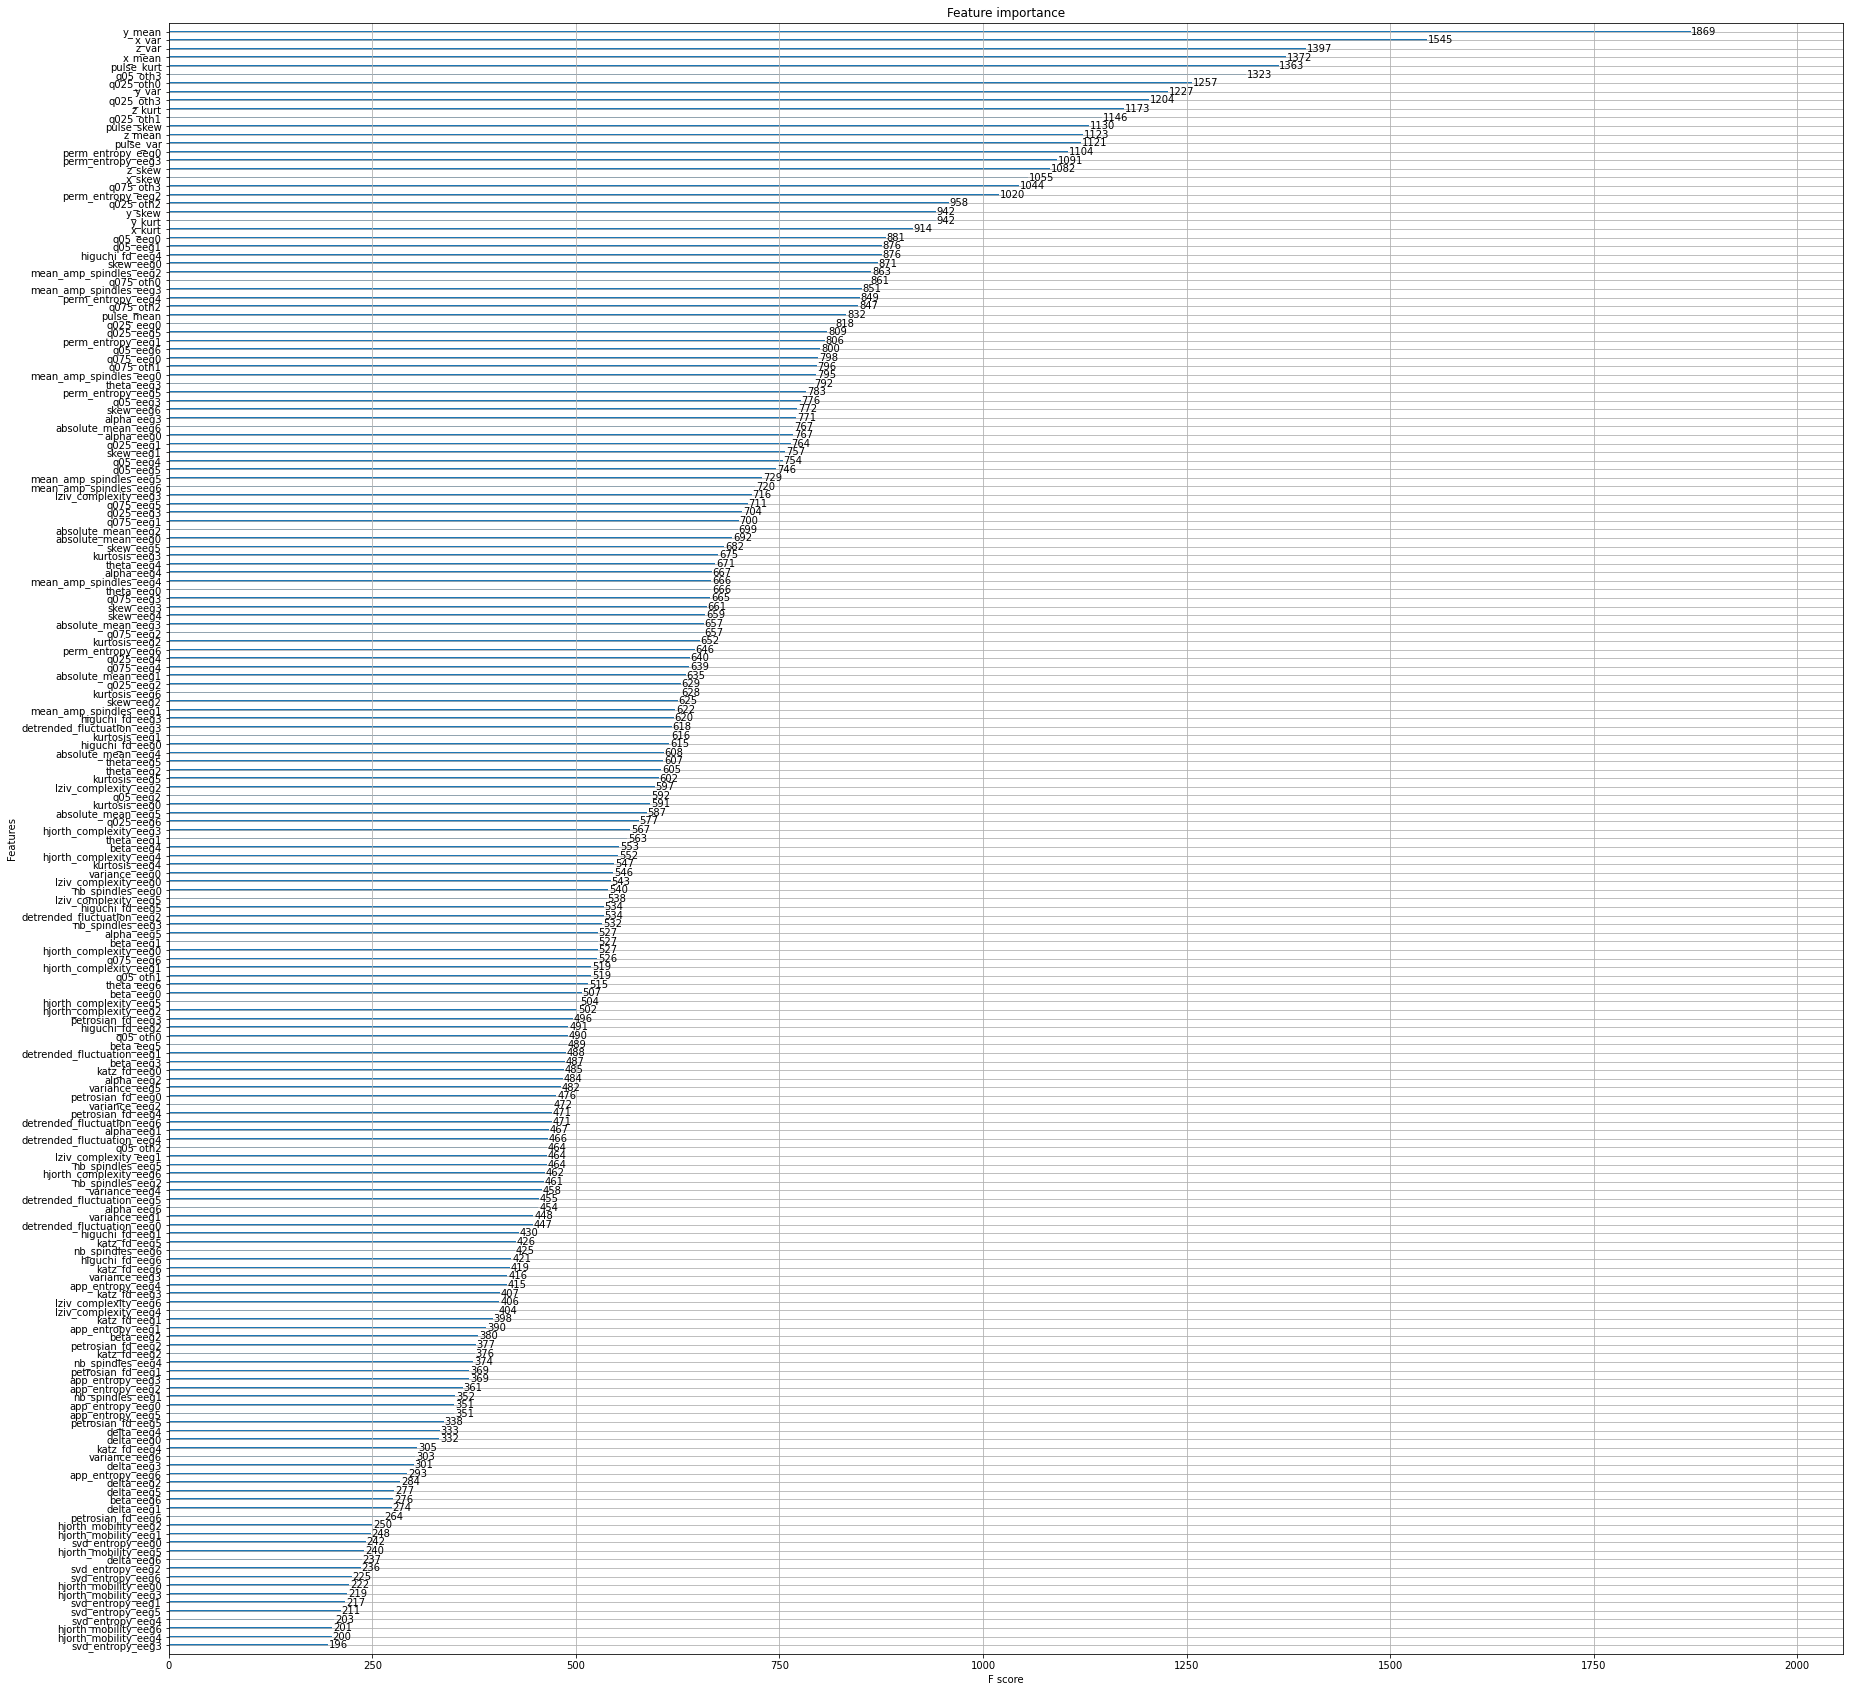

In [ ]:
# On affiche les features importances (ce qui nous a incité à supprimer les 7 features fisher_information)
import matplotlib.pyplot as plt
xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show() # ici les fisher sont déja supprimées

In [ ]:
# Prédiction
import numpy as np
preds = bst.predict(dtest)

# Car preds est un array de probabilité d'appartenance à chaque classe
predict = np.asarray([np.argmax(line) for line in preds])

# Class & Grid Search for XGBoost


In [ ]:
from sklearn.model_selection import GridSearchCV
sys.path.append('xgboost/wrapper/')

class XGBoostClassifier():
    def __init__(self, num_boost_round=10, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'multi:softprob'})
        self.params.update({'num_class': 5})
 
    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        self.label2num = {label: i for i, label in enumerate(sorted(set(y)))}
        dtrain = xgb.DMatrix(X, label=[self.label2num[label] for label in y])
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)
 
    def predict(self, X):
        num2label = {i: label for label, i in self.label2num.items()}
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])
 
    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)
 
    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / logloss(y, Y)
 
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self
    
def search_params_xgboost():
    clf = XGBoostClassifier(
        eval_metric = 'auc',
        num_class = 5,
        nthread = 4,
        silent = 1,
        )
    parameters = {
        'num_boost_round': [500, 600, 700],
        'eta': [0.05, 0.1, 0.3],
        'max_depth': [6, 9, 12],
        'learning_rate': [0.1, 0.15],
    }
    clf = GridSearchCV(clf, parameters, n_jobs=1, cv=2)
    
    clf.fit(features_eeg_1_train, Y_train.sleep_stage)
    best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
    print('score:', score)
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))


In [ ]:
search_params_xgboost() 

# Ecriture du predict a soumettre

In [ ]:
with open("predict.csv", "w") as f:
  f.write("index,sleep_stage\n")
  for i in range(features_test.shape[0]):
    f.write(str(features_train.shape[0] + i) + "," + str(predict[i]) + "\n")

In [ ]:
predict

# Hypnogramme final

Text(0.5, 1.0, 'Hypnogramme (en heures)')

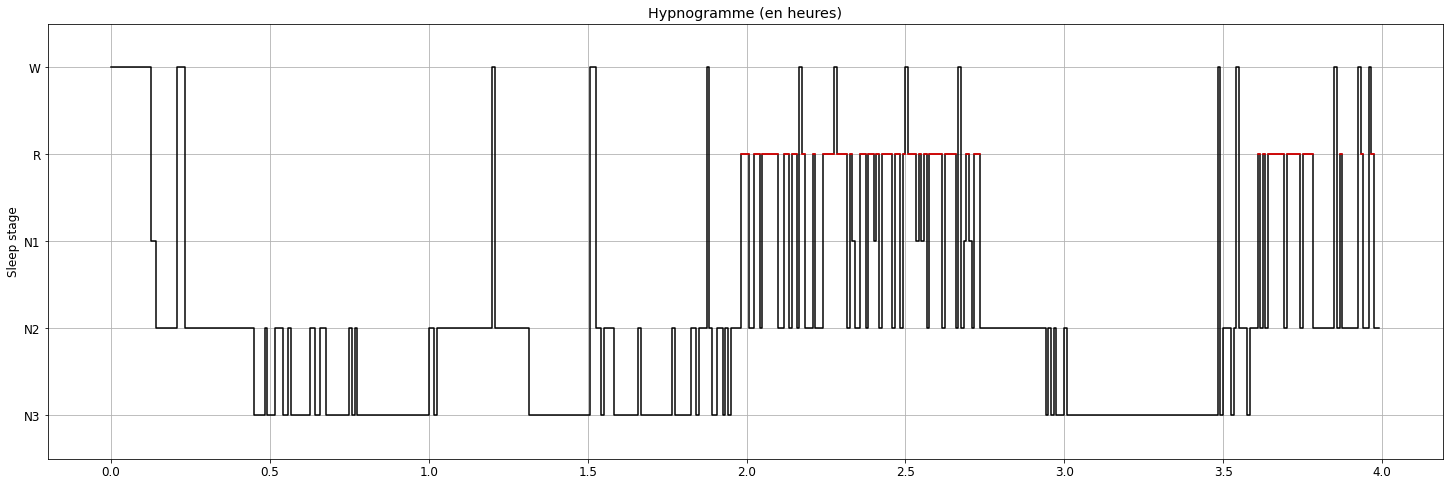

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(25, 8))
ax.grid()
hypno = pd.Series(predict.sleep_stage).map({0: 0, 1: -2, 2: -3, 3: -4, 4: -1}).values
hypno_rem = np.ma.masked_not_equal(hypno, -1)
times = np.arange(hypno.shape[0]) / 120 # pour convertir en heure
until = 480 # 30s * (480) = 4h

ax.step(times[:until], hypno[:until], color='k')
ax.step(times[:until], hypno_rem[:until], color='r')
ax.set_yticks([0, -1, -2, -3, -4])
ax.set_yticklabels(['W', 'R', 'N1', 'N2', 'N3'])
ax.set_ylim(-4.5, 0.5)
ax.set_ylabel('Sleep stage')
ax.set_title("Hypnogramme (en heures)")